# Cell/Nuclei Neighborhood Diversities

The neighborhood of a cell is defined by the cells that are within a certain distance from the cell. These neighborhoods show spatial patterns related to cell-cell interactions. Often, we are interested how diverse or heterogenous or homogenous the neighborhoods are which can tell us whether there exist some non-random patterns in the spatial distribution of the cell-cell interactions.

In this notebook, we will be looking at different ways to compute neighborhood diversities for the cells.

Note: This notebook is the same as the previous notebook until we start to compute diversity metrics.

## The Data

We'll be taking a look at a small tile of cells at the tumor-stroma interface i.e. at the border where the tumor meets stroma. The tumor in the data also contains a couple small blood vessels that introduce tumor-stroma interface within the tumor.

<Axes: >

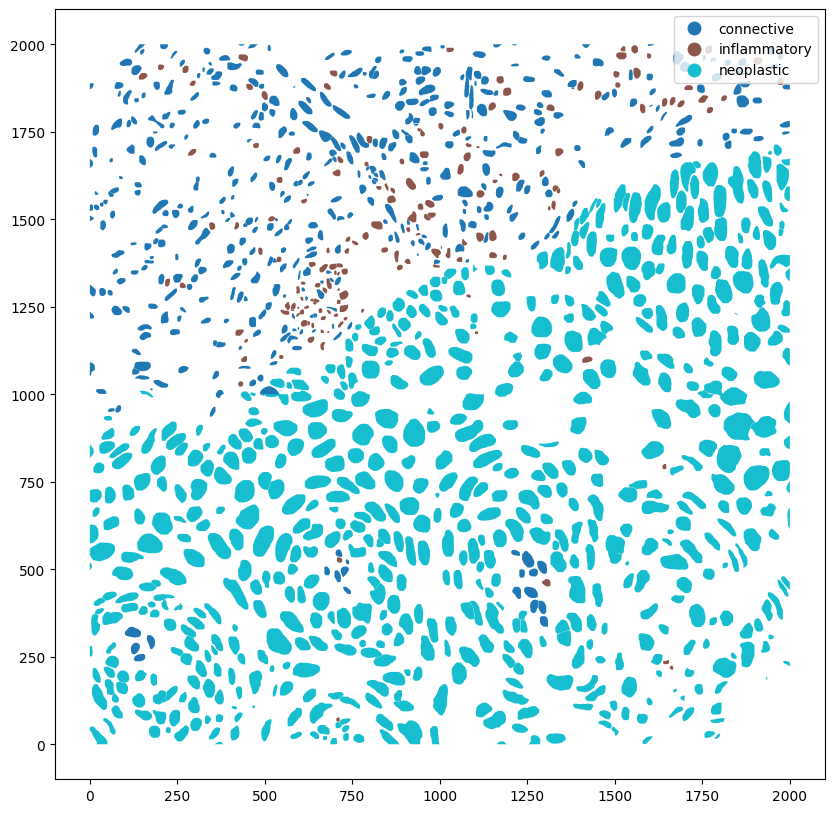

In [1]:
from cellseg_gsontools.data import tumor_stroma_intreface_cells

tsc = tumor_stroma_intreface_cells()
tsc.plot(column="class_name", figsize=(10,10), legend=True)

In [2]:
tsc

type                                           geometry    class_name
0     Feature  POLYGON ((169.012 42.997, 170.011 45.994, 174....    neoplastic
1     Feature  POLYGON ((183.996 97.988, 192.079 94.544, 194....    neoplastic
2     Feature  POLYGON ((130.006 97.989, 133.003 98.988, 136....    neoplastic
3     Feature  POLYGON ((63.174 103.174, 70.007 109.990, 72.0...    neoplastic
4     Feature  POLYGON ((122.012 131.995, 125.007 135.990, 13...    neoplastic
...       ...                                                ...           ...
1236  Feature  POLYGON ((1853.012 1950.996, 1854.010 1952.993...    connective
1237  Feature  POLYGON ((1774.012 1955.996, 1775.010 1957.993...    connective
1238  Feature  POLYGON ((1751.012 1965.997, 1752.011 1968.994...    connective
1239  Feature  POLYGON ((1758.012 1984.997, 1759.011 1987.995...  inflammatory
1240  Feature  POLYGON ((1937.012 1988.996, 1938.010 1990.993...    connective

[1241 rows x 3 columns]

## Spatial Weights

To get the neighborhoods of the cells, we will first fit a connectivity graph (called spatial weights in geospatial analysis jargon) to the `GeoDataFrame`. `cellseg_gsontools` provides a `fit_graph` function which can be used to do that. The actual fitting is done with the `libpysal` package and the `fit_graph`-function is basically a wrapper around different graph fitting methods. The allowed spatial weights are:

- `knn`: k-nearest neighbors
- `delaunay` - Delaunay triangulation
- `distband` - Distance band i.e. a distance thresholded knn graph
- `relative_nhood` - Relative neighborhood graph

We will be using the `delaunay` method in this example, however, note that for large data the `delaunay` method can get quite slow and for example the `distband` method is a lot faster. Here, we will set a distance threshold for the neighbors to be within 50 microns of the cell centroid. The distance unit in the example data is in pixels so 50 microns in pixels of 20x magnified segmentation mask is around 50*2 = 100 pixels.

In [3]:
from cellseg_gsontools.graphs import fit_graph
from cellseg_gsontools.utils import set_uid

# To fit the delaunay graph, we need to set a unique id for each cell first
tsc = set_uid(tsc, id_col="uid")
w = fit_graph(tsc, type="delaunay", thresh=100, id_col="uid")
w

<Axes: >

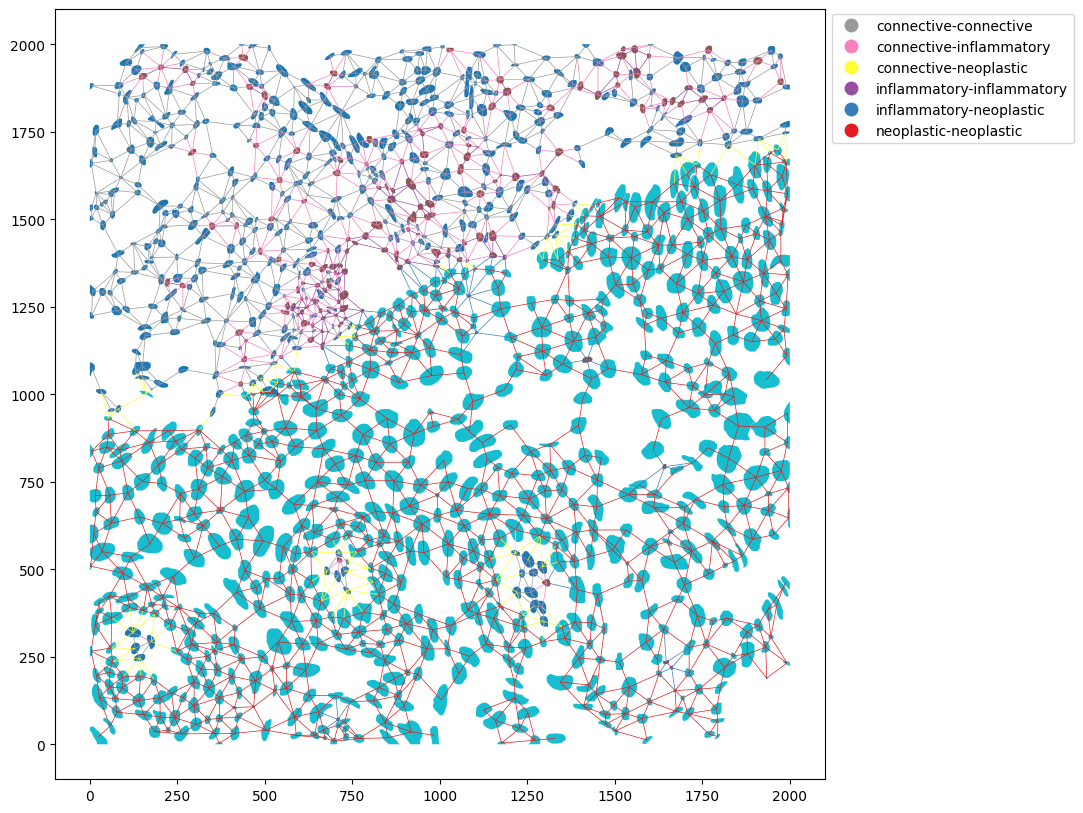

In [4]:
# let's convert the graph to a dataframe and plot it
from cellseg_gsontools.links import weights2gdf

wdf = weights2gdf(tsc, w)
ax = tsc.plot(column="class_name", figsize=(10,10), legend=True)
wdf.plot(
    ax=ax,
    linewidth=0.5,
    column="class_name",
    cmap="Set1_r",
    legend=True,
    legend_kwds={
        "loc": "center left",
        "bbox_to_anchor": (1.0, 0.91)
    }
)

## Diversity Metrics

We will compute four different diversity metrics that are available in `cellseg_gsontools` and then visualize them. The available metrics are:

- Shannon Entropy
- Simpson Index
- Gini Index
- Theil Index

Note that Gini Index and Theil index can be only computed for real valued data, thus we will have to compute some morpholgical metrics of the cells to compute these diversity metrics. For the simpson and shannon index, we can use the cell type information directly which is categorical.

## Shannon and Simpson Indices for Cell Type Diversity

Let's now compute the shannon diversity and simpson diversity indices. We will use the cell type attribute for the computations. Basically these metrics measure how homogenous/heterogenous the cell types are in each neighborhood. The diversity indices are computed with the `local_diversity` function.

In [5]:
from cellseg_gsontools.diversity import local_diversity

tsc = local_diversity(
    tsc,
    w,
    val_col="class_name",
    id_col="uid",
    metrics=("simpson_index", "shannon_index"),
    parallel=True,
)

tsc

type                                           geometry  \
uid                                                                
0     Feature  POLYGON ((169.012 42.997, 170.011 45.994, 174....   
1     Feature  POLYGON ((183.996 97.988, 192.079 94.544, 194....   
2     Feature  POLYGON ((130.006 97.989, 133.003 98.988, 136....   
3     Feature  POLYGON ((63.174 103.174, 70.007 109.990, 72.0...   
4     Feature  POLYGON ((122.012 131.995, 125.007 135.990, 13...   
...       ...                                                ...   
1236  Feature  POLYGON ((1853.012 1950.996, 1854.010 1952.993...   
1237  Feature  POLYGON ((1774.012 1955.996, 1775.010 1957.993...   
1238  Feature  POLYGON ((1751.012 1965.997, 1752.011 1968.994...   
1239  Feature  POLYGON ((1758.012 1984.997, 1759.011 1987.995...   
1240  Feature  POLYGON ((1937.012 1988.996, 1938.010 1990.993...   

        class_name   uid  class_name_simpson_index  class_name_shannon_index  
uid                                                                           
0       neoplastic     0                  0.000000                  0.000000  
1       neoplastic     1                  0.000000                  0.000000  
2       neoplastic     2                  0.000000                  0.000000  
3       neoplastic     3                  0.000000                  0.000000  
4       neoplastic     4                  0.000000                  0.000000  
...            ...   ...                       ...                       ...  
1236    connective  1236                  0.320000                  0.500402  
1237    connective  1237                  0.320000                  0.500402  
1238    connective  1238                  0.244898                  0.410116  
1239  inflammatory  1239                  0.320000                  0.500402  
1240    connective  1240                  0.320000                  0.500402  

[1241 rows x 6 columns]

Let's plot the diversity metrics

<Axes: title={'center': 'class_name_shannon_index'}>

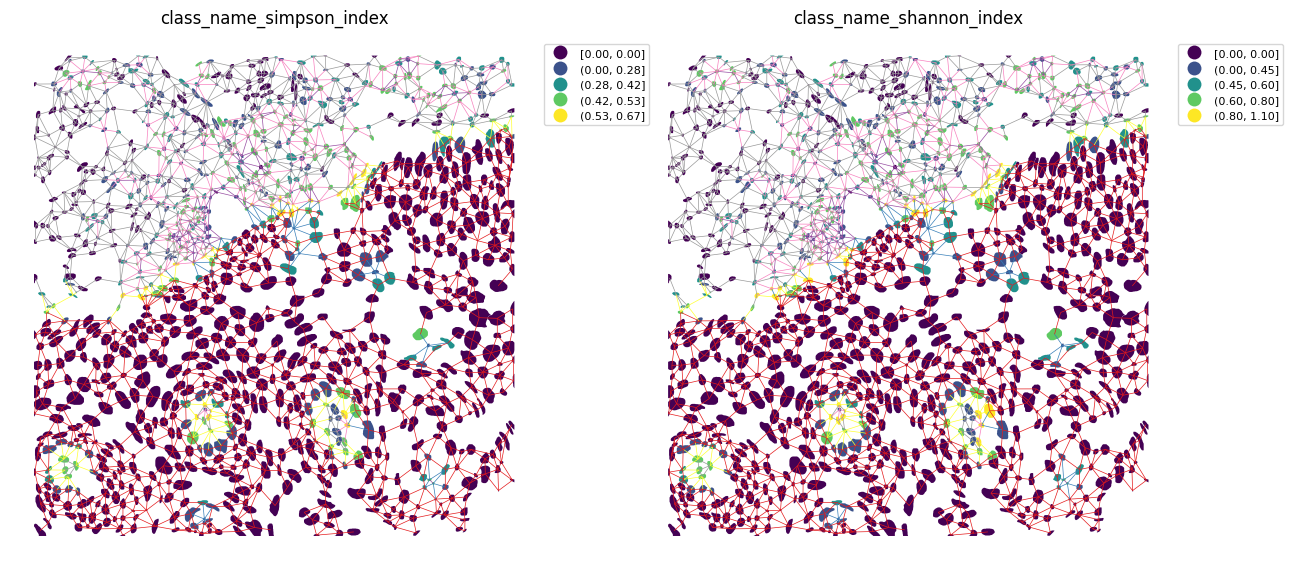

In [6]:
import matplotlib.pyplot as plt
import mapclassify

# helper function to replace legend items
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)


def plot_diversity(ax, cells, col, plot_weights=True):
    # bin the values with the FisherJenks method for visualization
    bins = mapclassify.FisherJenks(cells[col], k=5)
    cells["bin_vals"] = bins.yb
    ax = cells.plot(
        ax=ax,
        column="bin_vals",
        categorical=True,
        cmap="viridis",
        legend=True,
        legend_kwds={
            "fontsize": 8,
            "loc": "center left",
            "bbox_to_anchor": (1.0, 0.90),
        },
    )

    bin_legends = bins.get_legend_classes()
    mapping = dict([(i, s) for i, s in enumerate(bin_legends)])
    replace_legend_items(ax.get_legend(), mapping)
    ax.set_title(col)
    
    if plot_weights:
        ax = wdf.plot(
            ax=ax,
            linewidth=0.5,
            column="class_name",
            cmap="Set1_r",
        )
    ax.set_axis_off()

    return ax

fig, ax = plt.subplots(1, 2, figsize=(15, 15))

plot_diversity(ax[0], tsc, "class_name_simpson_index", plot_weights=True)
plot_diversity(ax[1], tsc, "class_name_shannon_index", plot_weights=True)


We can see from the above plots that the metrics produce nearly identical results. Basically, the most diverse neighborhoods are located at the tissue interfaces i.e. at the small blood vessels inside the tumor and directly at the tumor-stroma interface, where there are diverse neighborhoods of stromal cells, tumor cells, and lymphocytes.

## Gini and Theil Indices for Morphological Diversity

Let's now compute the Theil and Gini indices. These metrics are often used in econometrics to compute income inequality. Here, we will use the morphological metrics of the cells to compute these metrics. So basically we will compute the ineqaulity of the morphological metrics of the cells in each neighborhood.

### Computing Morphological Metrics

In [7]:
from cellseg_gsontools.geometry import shape_metric

# compute a couple shape metrics
metrics = [
    "area",
    "eccentricity",
    "sphericity",
    "fractal_dimension"
]

tsc = shape_metric(
    tsc,
    metrics=metrics,
    parallel=True,
)

tsc.head(4)

type                                           geometry  class_name  \
uid                                                                           
0    Feature  POLYGON ((169.012 42.997, 170.011 45.994, 174....  neoplastic   
1    Feature  POLYGON ((183.996 97.988, 192.079 94.544, 194....  neoplastic   
2    Feature  POLYGON ((130.006 97.989, 133.003 98.988, 136....  neoplastic   
3    Feature  POLYGON ((63.174 103.174, 70.007 109.990, 72.0...  neoplastic   

     uid  class_name_simpson_index  class_name_shannon_index  bin_vals  \
uid                                                                      
0      0                       0.0                       0.0         0   
1      1                       0.0                       0.0         0   
2      2                       0.0                       0.0         0   
3      3                       0.0                       0.0         0   

            area  eccentricity  sphericity  fractal_dimension  
uid                                                            
0     943.538625      0.405200    0.794631           0.405200  
1    1075.707286      0.435784    0.553602           0.435784  
2    1044.121328      0.822321    0.496494           0.822321  
3     833.673039      0.795212    0.556992           0.795212

Let's first plot the morphological metrics of the cells.

In [8]:
# !pip install legendgram

<Axes: >

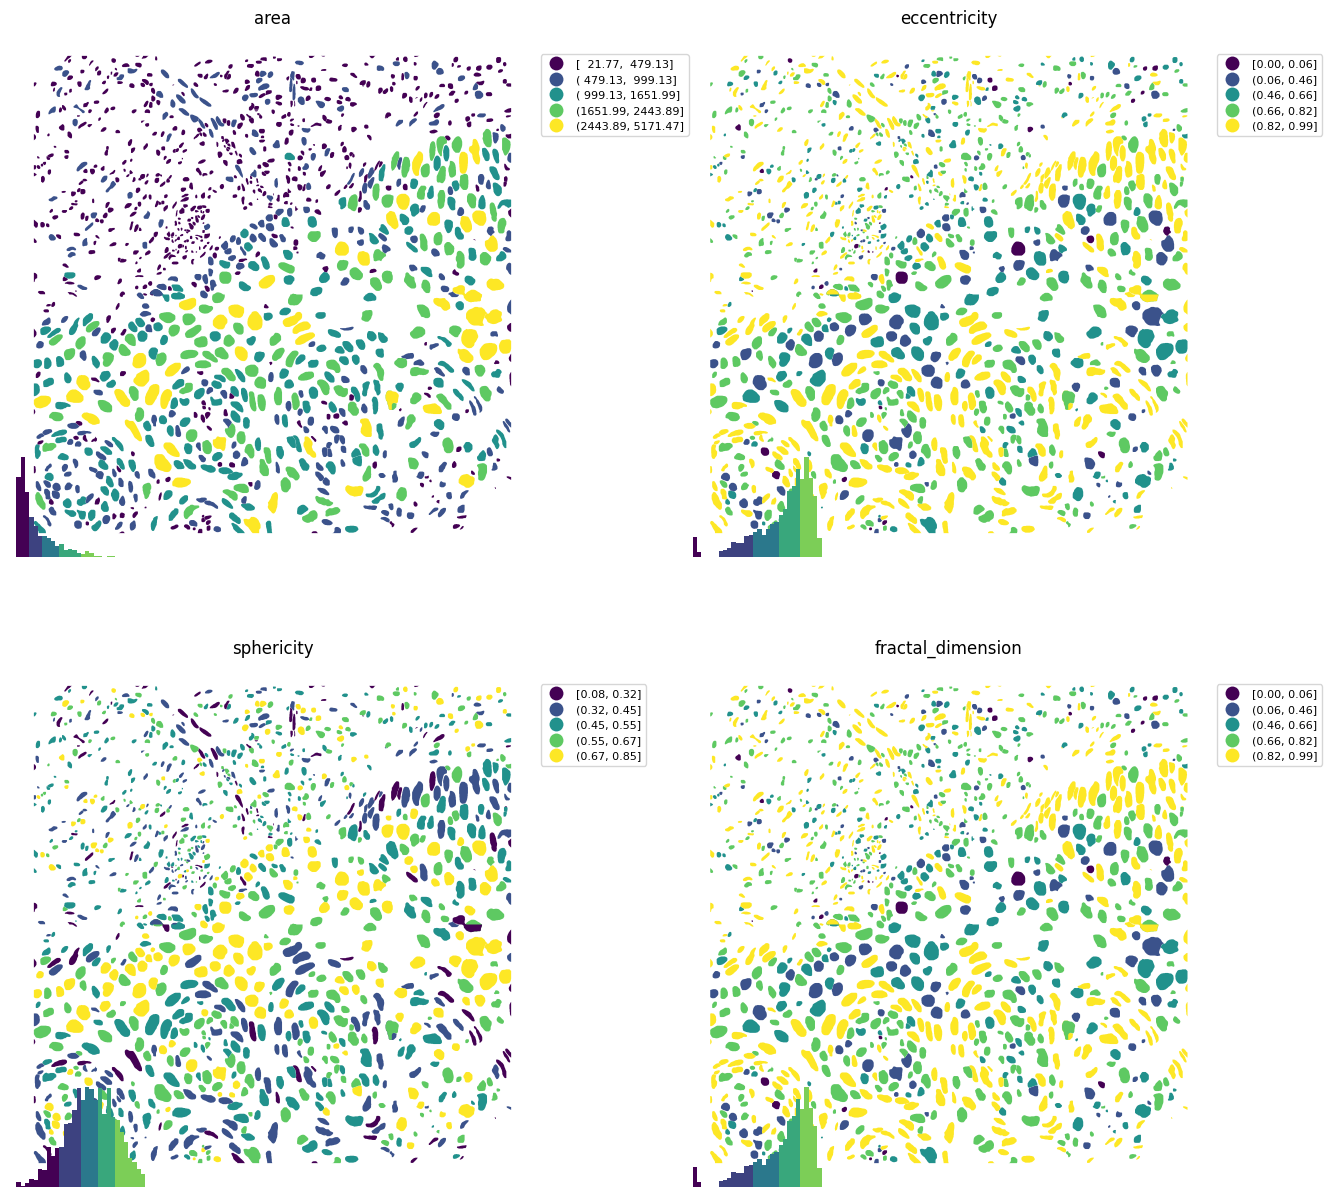

In [9]:
import geopandas as gpd
import palettable as palet
from legendgram import legendgram


    # Helper function to plot cells with a feature value highlighted
def plot_cells(f, ax, cells: gpd.GeoDataFrame, col: str):
    # bin the values with the Fisher-Jenks method
    bins = mapclassify.FisherJenks(cells[col], k=5)
    cells["bin_vals"] = bins.yb

    ax = cells.plot(
        ax=ax,
        column="bin_vals",
        cmap="viridis",
        categorical=True,
        legend=True,
        legend_kwds={
            "fontsize": 8,
            "loc": "center left",
            "bbox_to_anchor": (1.0, 0.88),
        },
    )

    bin_legends = bins.get_legend_classes()
    mapping = dict([(i, s) for i, s in enumerate(bin_legends)])
    replace_legend_items(ax.get_legend(), mapping)
    ax.set_axis_off()
    ax.set_title(col)
    ax = legendgram(
        f,
        ax,
        cells[col],
        bins=30,
        breaks=bins.bins,
        pal=palet.matplotlib.Viridis_5,
        loc="lower left",
    )
    ax.set_axis_off()

    return ax

fig, ax = plt.subplots(2, 2, figsize=(16, 15))
ax = ax.flatten()
plot_cells(fig, ax[0], tsc, "area")
plot_cells(fig, ax[1], tsc, "eccentricity")
plot_cells(fig, ax[2], tsc, "sphericity")
plot_cells(fig, ax[3], tsc, "fractal_dimension")


### Computing Gini and Theil Indices

In [10]:
from cellseg_gsontools.diversity import local_diversity

tsc = local_diversity(
    tsc,
    w,
    val_col=("area", "eccentricity"),
    id_col="uid",
    metrics=("gini_index", "theil_index"),
    parallel=True,
)

tsc

type                                           geometry  \
uid                                                                
0     Feature  POLYGON ((169.012 42.997, 170.011 45.994, 174....   
1     Feature  POLYGON ((183.996 97.988, 192.079 94.544, 194....   
2     Feature  POLYGON ((130.006 97.989, 133.003 98.988, 136....   
3     Feature  POLYGON ((63.174 103.174, 70.007 109.990, 72.0...   
4     Feature  POLYGON ((122.012 131.995, 125.007 135.990, 13...   
...       ...                                                ...   
1236  Feature  POLYGON ((1853.012 1950.996, 1854.010 1952.993...   
1237  Feature  POLYGON ((1774.012 1955.996, 1775.010 1957.993...   
1238  Feature  POLYGON ((1751.012 1965.997, 1752.011 1968.994...   
1239  Feature  POLYGON ((1758.012 1984.997, 1759.011 1987.995...   
1240  Feature  POLYGON ((1937.012 1988.996, 1938.010 1990.993...   

        class_name   uid  class_name_simpson_index  class_name_shannon_index  \
uid                                                                            
0       neoplastic     0                  0.000000                  0.000000   
1       neoplastic     1                  0.000000                  0.000000   
2       neoplastic     2                  0.000000                  0.000000   
3       neoplastic     3                  0.000000                  0.000000   
4       neoplastic     4                  0.000000                  0.000000   
...            ...   ...                       ...                       ...   
1236    connective  1236                  0.320000                  0.500402   
1237    connective  1237                  0.320000                  0.500402   
1238    connective  1238                  0.244898                  0.410116   
1239  inflammatory  1239                  0.320000                  0.500402   
1240    connective  1240                  0.320000                  0.500402   

      bin_vals         area  eccentricity  sphericity  fractal_dimension  \
uid                                                                        
0            1   943.538625      0.405200    0.794631           0.405200   
1            1  1075.707286      0.435784    0.553602           0.435784   
2            4  1044.121328      0.822321    0.496494           0.822321   
3            3   833.673039      0.795212    0.556992           0.795212   
4            1  1167.520029      0.266585    0.809407           0.266585   
...        ...          ...           ...         ...                ...   
1236         0   432.189909      0.032139    0.718006           0.032139   
1237         3   137.291665      0.726723    0.447882           0.726723   
1238         4   124.983503      0.827244    0.358475           0.827244   
1239         2   381.149497      0.494062    0.689854           0.494062   
1240         2   465.555405      0.542822    0.729013           0.542822   

      area_gini_index  area_theil_index  eccentricity_gini_index  \
uid                                                                
0            0.187302          0.103848                 0.159341   
1            0.165736          0.087905                 0.216479   
2            0.062130          0.006462                 0.260549   
3            0.262713          0.114134                 0.168073   
4            0.170704          0.051128                 0.211602   
...               ...               ...                      ...   
1236         0.082873          0.018006                 0.445169   
1237         0.309179          0.157230                 0.283330   
1238         0.307508          0.164763                 0.165414   
1239         0.379105          0.245069                 0.293331   
1240         0.164228          0.052950                 0.246897   

      eccentricity_theil_index  
uid                             
0                     0.043538  
1                     0.077780  
2                     0.114022  
3                     0.061453  
4          

<Axes: title={'center': 'eccentricity_gini_index'}>

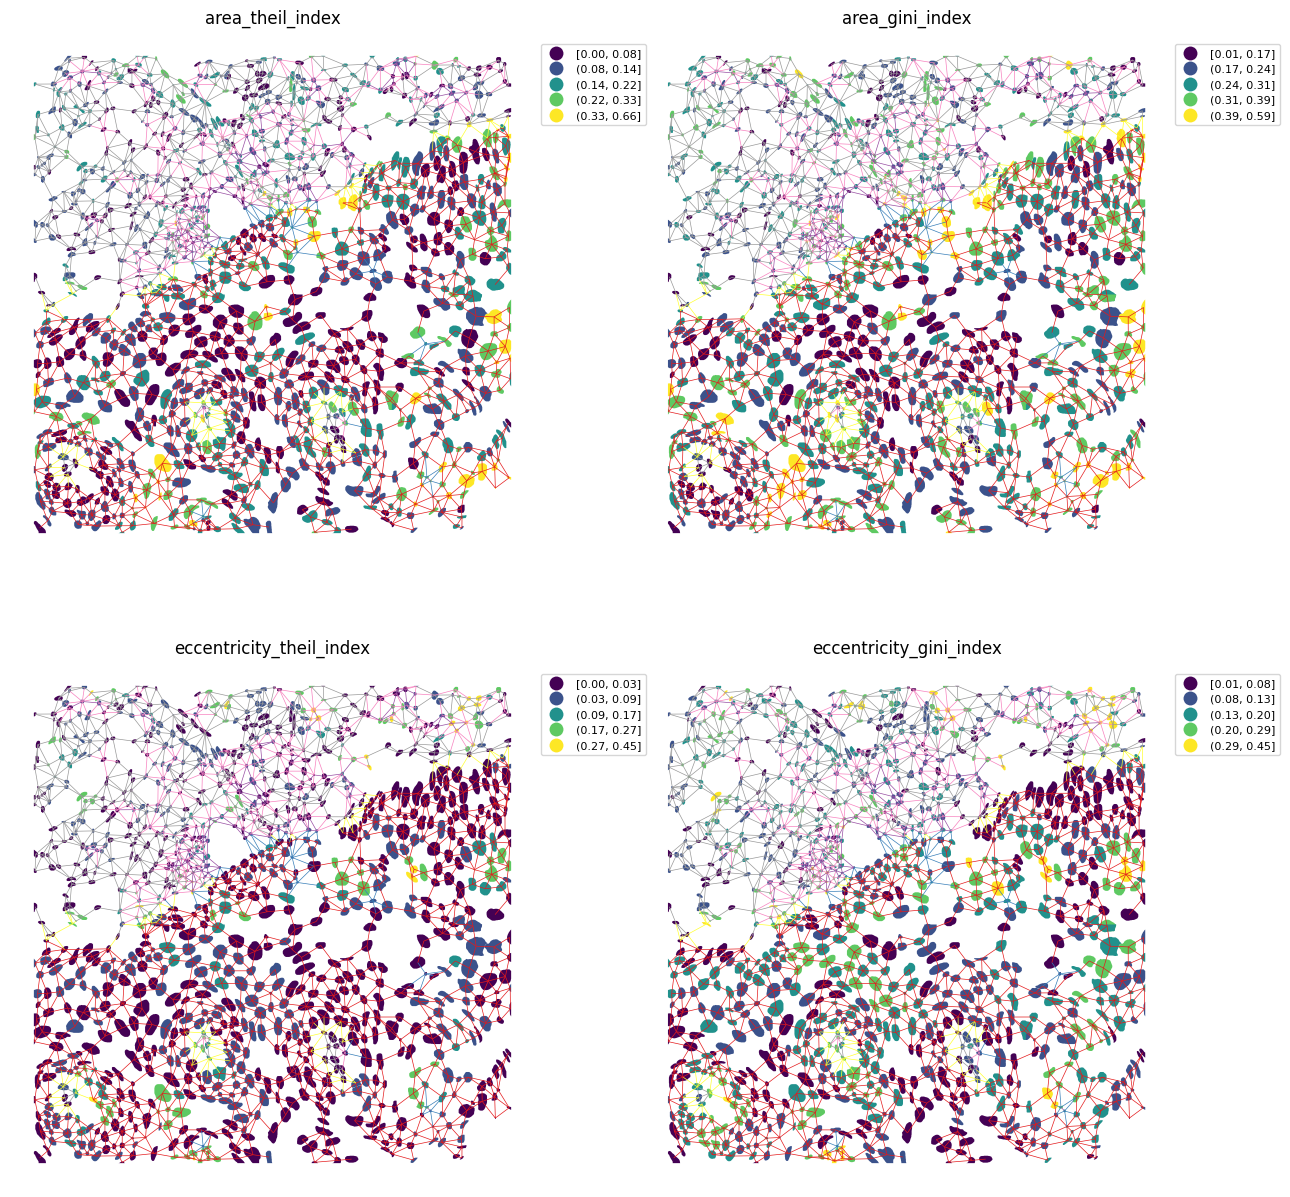

In [11]:
# Aand some plots

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.flatten()

plot_diversity(ax[0], tsc, "area_theil_index", plot_weights=True)
plot_diversity(ax[1], tsc, "area_gini_index", plot_weights=True)
plot_diversity(ax[2], tsc, "eccentricity_theil_index", plot_weights=True)
plot_diversity(ax[3], tsc, "eccentricity_gini_index", plot_weights=True)


As expected, the Theil an Gini inequality indicices of eccentric cells are low around the tissue interfaces. This means that the eccentricity of the cells is more homogenous around the tissue interfaces which can be seen from the previous plots where the elliptic cells cluster around the tissue interfaces. On the other hand, the Theil and Gini indices of the cell areas are high around the tissue interfaces which means that the cell area is more heterogenous around the tissue interfaces.